In [1]:
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
from tensorflow import keras
import tensorflow as tf
import pandas as pd
import numpy as np
import shutil

from pathlib import Path
import ntpath
import os

### GLOBAL ###
# Kaggle needs a slash before so: /kaggle/input/hotel-id-2022-fgvc9/
SEED = 42
PROJECT_FOLDER = "../data/"
#PROJECT_FOLDER = "../input/hotel-id-to-combat-human-trafficking-2022-fgvc9/"
TRAIN_DATA_FOLDER = PROJECT_FOLDER + "train_images/"
TEST_DATA_FOLDER = PROJECT_FOLDER + "test_images/"

IMAGE_SIZE = (224, 224)
VAL_SPLIT = 0.2

assert os.path.exists(PROJECT_FOLDER), "Missing data folder"
assert os.path.exists(TRAIN_DATA_FOLDER), "Missing train folder"
assert os.path.exists(TEST_DATA_FOLDER), "Missing test folder"

In [3]:
labels = pd.read_csv('tools/bathroom_subset_manual_labels.csv', header=None)
labels[1] = pd.to_numeric(labels[1])
labels

,0,1
0,000000441.jpg,0
1,000000442.jpg,2
2,000000443.jpg,2
3,000000444.jpg,2
4,000000445.jpg,2
...,...,...
2076,000044211.jpg,0
2077,000044212.jpg,0
2078,000044214.jpg,1
2079,000044215.jpg,1


## Create bathroom-bedroom dataset

In [4]:
# Create bathroom dataset
result = list(Path(PROJECT_FOLDER).rglob("*.[jJ][pP][gG]"))

for image_path in result:
    image_name = ntpath.basename(image_path)
    if image_name == "abc.jpg": continue #skip sample bathroom
    class_id = labels.loc[labels[0] == image_name][1].values[0]
    if class_id > 1: class_id = 0 # only distinguish bathrooms
    dest_folder = f"../data_bathroom/train_images/{class_id}/{image_name}"
    if os.path.exists(dest_folder+""): continue
    shutil.copy(image_path, dest_folder)

## TRAIN DISTINGUISHER

In [5]:
PROJECT_FOLDER_BATH = "../data_bathroom/"
TRAIN_BATH_DATA_FOLDER = PROJECT_FOLDER_BATH + "train_images/"
TEST_BATH_DATA_FOLDER = PROJECT_FOLDER_BATH + "test_images/"

In [ ]:
train_ds = image_dataset_from_directory(
    directory=TRAIN_BATH_DATA_FOLDER,
    labels='inferred',
    label_mode='binary',
    batch_size=64,
    image_size=IMAGE_SIZE,
    seed=1338,
    crop_to_aspect_ratio=True,
    subset='training',
    validation_split=VAL_SPLIT
)

val_ds = image_dataset_from_directory(
    directory=TRAIN_BATH_DATA_FOLDER,
    labels='inferred',
    label_mode='binary',
    batch_size=64,
    seed=1338,
    image_size=IMAGE_SIZE,
    crop_to_aspect_ratio=True,
    subset='validation',
    validation_split=VAL_SPLIT
)

test_ds = image_dataset_from_directory(
    directory=TEST_BATH_DATA_FOLDER,
    labels='inferred',
    label_mode='binary',
    batch_size=64,
    seed=1338,
    image_size=IMAGE_SIZE,
    crop_to_aspect_ratio=True,
    #validation_split=0.1
)

### Apply random masking

In [7]:
from numpy.random import default_rng
import matplotlib.pyplot as plt
rng = default_rng()

In [8]:
import tensorflow_addons as tfa

def random_cutout(images_tensor, labels):
    ratios_x = rng.uniform(0.1, 0.5)*images_tensor.shape[1]
    ratios_y = rng.uniform(0.1, 0.5)*images_tensor.shape[2]

    xs_mask = tf.cast(ratios_x, tf.int32)
    xs_mask = xs_mask if xs_mask % 2 == 0 else xs_mask+1 # force number even

    ys_mask = tf.cast(ratios_y, tf.int32)
    ys_mask = ys_mask if ys_mask % 2 == 0 else ys_mask+1 # force number even

    return tfa.image.random_cutout(images_tensor, (xs_mask, ys_mask), constant_values = (255.0, 0.0, 0.0)), labels

In [9]:
train_ds_masked = train_ds.map(random_cutout)
val_ds_masked = val_ds.map(random_cutout)
test_ds_maksed = test_ds.map(random_cutout)

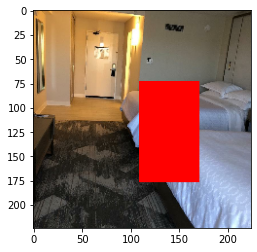

In [10]:
plt.imshow(next(iter(train_ds_masked))[0][0]/255)

In [11]:
def create_model_eNetB0():
    layer = tf.keras.applications.EfficientNetB0(
            include_top=True,
            weights="imagenet")
    layer.trainable = False
    model = keras.Sequential([
        layer,
        keras.layers.Dense(512, activation='selu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.summary()

    model.compile(
        optimizer='adam',
        #loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

    checkpoint_filepath = 'ckp'
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True),
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
    ]
    return model, callbacks


In [12]:
model, callbacks = create_model_eNetB0()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1000)             5330571   
                                                                 
 dense (Dense)               (None, 512)               512512    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 5,843,596
Trainable params: 513,025
Non-trainable params: 5,330,571
_________________________________________________________________


In [ ]:
history = model.fit(train_ds_masked, callbacks=callbacks, epochs=50, validation_data=val_ds_masked)

In [14]:
# load best checkpoint
model.load_weights('ckp')
model.evaluate(test_ds)

4/4 [==============================] - 2s 426ms/step - loss: 0.1175 - accuracy: 0.9700


[0.11753367632627487, 0.9700000286102295]

In [15]:
model.evaluate(test_ds_maksed)

4/4 [==============================] - 2s 199ms/step - loss: 0.1341 - accuracy: 0.9650


[0.1340683400630951, 0.9649999737739563]

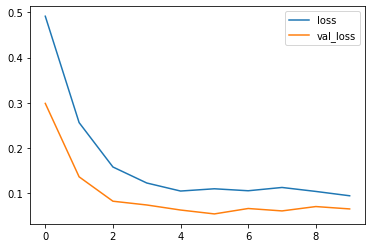

In [16]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

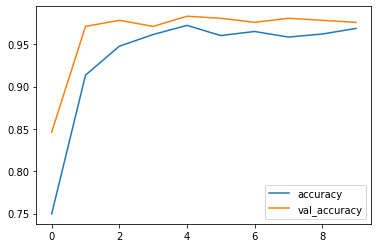

In [17]:
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [ ]:
model.save('../models/bath_classifier_97percent_30_05_2022')

In [1]:
import pandas as pd

In [4]:
a = pd.read_pickle("/mnt/c/Users/Pedro/OneDrive/Documentos/1º Data Science/ML/project 2/mlip-hotel-id/tools/mask_statistics_sample.pkl")

<AxesSubplot:ylabel='Frequency'>

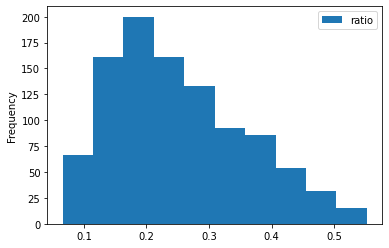

In [15]:
a.plot.hist(y='ratio')

In [14]:
a

,image_id,size,num_pixels,ratio
1,03096.png,"(1024, 768)",159160,0.2024
2,03978.png,"(768, 1024)",187600,0.2385
3,02481.png,"(768, 1024)",130416,0.1658
4,02354.png,"(2268, 4032)",3026092,0.3309
5,04580.png,"(3000, 4000)",3518840,0.2932
...,...,...,...,...
997,05213.png,"(1024, 768)",275220,0.35
998,03748.png,"(768, 1024)",247694,0.315
999,00791.png,"(2160, 3840)",1887270,0.2275
1000,04647.png,"(2160, 3840)",3299268,0.3978
